In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('FIFA_train.csv',encoding = 'utf-8') # train data
test = pd.read_csv("FIFA_test.csv",encoding = 'utf-8') # test data
submission = pd.read_csv('submission.csv',encoding='utf-8')

In [3]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


### 파생변수

In [4]:
def create_new_variable(df):
    # 데이터프레임을 복사하여 새로운 데이터프레임을 생성
    new_df = df.copy()
    
    # position별로 stat_overall과 stat_potential의 평균을 구함
    position_stat = new_df.groupby('position')[['stat_overall', 'stat_potential']].mean()
    
    # 기존 데이터프레임과 position_stat를 join하여 새로운 데이터프레임을 생성
    new_df = new_df.join(position_stat.add_suffix('_mean'), on='position')
    
    # stat_overall_dif 변수와 sod*re 변수를 생성
    new_df['stat_overall_dif'] = new_df['stat_overall'] - new_df['stat_overall_mean']
    new_df['sod*re'] = new_df['stat_overall_dif'] * new_df['reputation']
    
    # stat_potential_dif 변수와 spd*re 변수를 생성
    new_df['stat_potential_dif'] = new_df['stat_potential'] - new_df['stat_potential_mean']
    new_df['spd*re'] = new_df['stat_potential_dif'] * new_df['reputation']
    
    # 수학적 기법인 가중조화평균을 이용해 가중치(reputation)으로 raw data에서 상관관계가 높은 변수로 만들어봄
    new_df['egi'] = (new_df['reputation'] ** 0.5 * (new_df['stat_overall'] * new_df['stat_potential']) ** 0.5) / (new_df['reputation'] ** 0.5 + (new_df['stat_overall'] * new_df['stat_potential']) ** 0.5)
    
    # 나이별 그룹을 만들어서 가중치를 두고 분석에 이용
    new_df['age_group'] = pd.cut(new_df['age'], 
                                 bins=[0, 20, 25, 30, 100], 
                                 labels=['under 20', '20-25', '26-30', 'over 30'])
    
    age_group_level_map = {
    'under 20' :    4,
    '20-25'    :    3, 
    '26-30'       :    2,
    'over 30'        :    1, 
    } 
    
    new_df['age_group_level'] = new_df['age_group'].map(age_group_level_map)
    new_df['age_group_level'] = new_df['age_group_level'].astype('float64')
    new_df['agl*spdre'] = new_df['age_group_level'] * new_df['spd*re']
    
    # 유망주에 관한 변수 생성
    new_df['youth'] = (new_df['stat_overall'] * new_df['reputation']) / new_df['age']
    
    # 포지션별 선수 순위를 내림차순으로 정리하는 position_rank 변수 생성
    new_df['position_rank'] = new_df.groupby('position')['stat_overall'].rank(ascending=True)
    
    # position_rank를 가중치인 reputation 변수와 곱해 새로운 파생변수 생성(corr=0.68)
    new_df['position_rank*stat_potential']= new_df['position_rank'] * new_df['stat_potential']
    
    # 파생변수를 선택하여 반환
    return new_df[['sod*re', 'spd*re', 'egi', 'age_group', 'age_group_level', 'agl*spdre', 'position_rank', 'position_rank*stat_potential', 'youth']]

In [5]:
train = pd.merge(train, create_new_variable(train), left_index=True, right_index=True)

<AxesSubplot: >

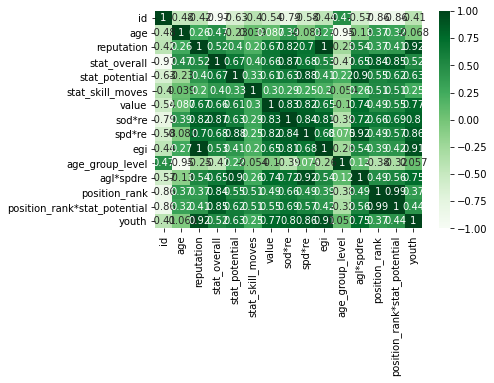

In [6]:
#heatmap으로 상관관계를 표시
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["figure.figsize"] = (10,10)
sb.heatmap(train.corr(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

In [7]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,...,value,sod*re,spd*re,egi,age_group,age_group_level,agl*spdre,position_rank,position_rank*stat_potential,youth
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,...,110500000.0,133.498534,107.149560,2.184112,over 30,1.0,107.149560,1705.0,160270.0,15.161290
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,...,72000000.0,103.246032,89.376984,1.957444,26-30,2.0,178.753968,1008.0,93744.0,13.481481
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,...,80000000.0,118.498534,92.149560,2.182441,over 30,1.0,92.149560,1704.0,155064.0,14.677419
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,...,51000000.0,94.783232,77.314224,1.956989,over 30,1.0,77.314224,2791.0,253981.0,11.375000
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,...,68000000.0,74.434524,67.032738,1.699869,20-25,3.0,201.098214,1007.0,93651.0,10.800000


test data에 모델을 적용하기 위해서는 파생변수를 추가해줘야함.

In [8]:
test = pd.merge(test, create_new_variable(test), left_index=True, right_index=True)

In [9]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,sod*re,spd*re,egi,age_group,age_group_level,agl*spdre,position_rank,position_rank*stat_potential,youth
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0,131.945607,107.503487,2.184112,over 30,1.0,107.503487,717.0,67398.0,14.242424
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0,121.945607,102.503487,2.183289,26-30,2.0,205.006974,716.0,66588.0,17.692308
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0,93.369672,77.330538,1.957219,26-30,2.0,154.661076,1430.5,131606.0,13.481481
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0,93.556485,74.002789,1.956989,26-30,2.0,148.005579,715.0,65065.0,13.481481
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0,93.369672,73.330538,1.956989,over 30,1.0,73.330538,1430.5,130175.5,11.375000


In [10]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Split features and target variable
X = train.drop(['value', 'id', 'name'], axis=1)
y = train["value"]

# Define the base models
models = [
    LGBMRegressor(random_state=42),
    XGBRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False),
    RandomForestRegressor(random_state=42)
]

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use pandas' select_dtypes method to select categorical and numerical features
categorical_features = X.select_dtypes(include=['object'])
numerical_features = X.select_dtypes(include=['int64', 'float64'])

# Define transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features.columns),
    ('num', numerical_transformer, numerical_features.columns)
])

# Fit and transform the preprocessing pipeline on the training set
X_preprocessed = preprocessor.fit_transform(X)

# Transform the test set using the fitted preprocessing pipeline
test_preprocessed = preprocessor.transform(test)

# Initialize empty arrays for storing the predictions on the train set
train_predictions = np.zeros((X_preprocessed.shape[0], len(models)))
test_predictions = np.zeros((test_preprocessed.shape[0], len(models)))

# Define the number of folds for cross-validation
n_splits = 5

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through the models and fit them using cross-validation
for i, model in enumerate(models):
    print(f"Training model {i+1}")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_preprocessed, y)):
        # Split the data into training and validation sets for this fold
        train_features, train_target = X_preprocessed[train_idx], y.iloc[train_idx]
        val_features, val_target = X_preprocessed[val_idx], y.iloc[val_idx]

        # Fit the model on the training data for this fold
        model.fit(train_features, train_target)

        # Predict on the validation data for this fold
        val_predictions = model.predict(val_features)

        # Store the predictions for this fold in the train_predictions array
        train_predictions[val_idx, i] = val_predictions
        
    # Predict on the test set with the current model
    test_predictions[:, i] = model.predict(test_preprocessed)

# Scale the train and test predictions using a standard scaler
scaler = StandardScaler()
train_predictions_scaled = scaler.fit_transform(train_predictions)
test_predictions_scaled = scaler.transform(test_predictions)

# Define the meta-model
meta_model = LinearRegression()

# Fit the meta-model on the scaled train predictions
meta_model.fit(train_predictions_scaled, y)

# Predict on the scaled test predictions with the meta-model
meta_predictions = meta_model.predict(test_predictions_scaled)


# # Calculate the mean squared error of the meta-predictions on the test set
# rmse = mean_squared_error(y_test, meta_predictions)**0.5
# print(f"Meta-model RMSE on test set: {rmse:.4f}")


/home/dslab/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/dslab/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/dslab/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/dslab/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureW

Training model 1
Training model 2
Training model 3
Training model 4


In [11]:
meta_predictions

array([ 6.35359213e+07,  7.38201160e+07,  8.08971135e+07, ...,
       -7.92785838e+03,  3.29008373e+03, -4.10162034e+04])

In [13]:
submission['value']=meta_predictions

In [14]:
submission.to_csv('submission_JH.csv')